In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
from pykalman import KalmanFilter


In [52]:
class pair_trade:
    P_VALUE         = 0.05
    HURST           = 0.5                 # Checking Trend Persistance
    EXIT_PROFIT     = 0                   # Exit Point = 0 std
    TRADE_BOUND     = 1                  # Entry Point = 1 std
    STOP_LOSS       = 2                   # Stop Loss = 2 std
    TRADING_PERIOD  = 253

    def __init__ (self, raw_df, spread_option=str('normal'), trading_bound=TRADE_BOUND, exit_profit=EXIT_PROFIT, stop_loss=STOP_LOSS):
        
        '''raw_df is the original price df that including pairs' price history'''
        self.price_df      = raw_df
        self.trade_df      = np.log(raw_df).diff().dropna()

        self.asset_1_name  = self.trade_df.columns[0]
        self.asset_2_name  = self.trade_df.columns[1]

        self.trading_bound = trading_bound
        self.exit_profit   = exit_profit
        self.stop_loss     = stop_loss
        
        self.error = False

        try:
            if spread_option == str('normal'):
                model = sm.OLS(self.trade_df.iloc[:, 1], np.c_[np.ones((len(self.trade_df))), self.trade_df.iloc[:, 0]]).fit()
                beta = model.params[1]
                self.spread = self.trade_df.iloc[0, 1] - beta * self.trade_df.iloc[:, 0]
                self.normalized_spread = (self.spread - self.spread.mean()) / self.spread.std()
                self.p_value = coint(self.trade_df.iloc[:,0], self.trade_df.iloc[:,1])[1]
                self.hurst = compute_Hc(self.spread)[0]

            elif spread_option == str('kalman'):
                model = sm.OLS(self.trade_df.iloc[:, 1], np.c_[np.ones((len(self.trade_df))), self.trade_df.iloc[:, 0]]).fit()
                beta = model.params[1]
                self.spread = self.trade_df.iloc[0, 1] - beta * self.trade_df.iloc[:, 0]
                self.normalized_spread = (self.spread - self.spread.mean()) / self.spread.std()
                self.p_value = coint(self.trade_df.iloc[:,0], self.trade_df.iloc[:,1])[1]
                self.hurst = compute_Hc(self.spread)[0]                

        except Exception as e:
            print(e)
            print(f'Error!! Error!! Fucking Error!! with pairs {self.asset_1_name} & {self.asset_2_name}')
            self.error = True


    def eligible (self, p_value = P_VALUE, hurst = HURST):
        if self.error:
            return False
        elif self.p_value <= p_value and self.hurst <= hurst:
            return True
        return False

    def level_crosses(self, series, level=2):
        change=[]
        for i, el in enumerate(series):
            if i != 0 and el > level and series[i-1] < level:
                change.append(1)
            elif i != 0 and el < level and series[i-1] > level:
                change.append(-1)
            else:
                change.append(0)
        return change

    def get_normal_std_signal (self):

        upper_init = self.level_crosses(self.normalized_spread, level=  self.trading_bound)
        lower_init = self.level_crosses(self.normalized_spread, level= -self.trading_bound)
        upper_stop = self.level_crosses(self.normalized_spread, level=  self.stop_loss)
        lower_stop = self.level_crosses(self.normalized_spread, level= -self.stop_loss)
        mean       = self.level_crosses(self.normalized_spread, level=  self.exit_profit)

        open_position = False
        entry_level = 0

        self.stop_losses        = []
        self.open_positions     = []
        self.closed_positions   = []
        profits                 = []

        for i in range(0, len(self.normalized_spread)):
            if open_position:
                #stop loss
                if upper_stop[i] == 1 or lower_stop[i] == -1:
                    open_position = False
                    profits.append(-abs(self.spread[i] - entry_level))
                    self.stop_losses.append(i)
                #profit close
                elif mean[i] != 0:
                    open_position = False
                    profits.append(abs(self.spread[i] - entry_level))
                    self.closed_positions.append(i)
                else:
                    profits.append(0)

            else:
                #Entering The Position
                if upper_init[i] == -1 or lower_init[i] == 1:
                    open_position = True
                    entry_level = self.spread[i]
                    self.open_positions.append(i)
                profits.append(0)

        self.profit_series = pd.DataFrame(index=self.trade_df.index, data=profits, columns=[f'{self.asset_1_name}_{self.asset_2_name}'])
        self.cum_profits = self.profit_series.cumsum()
        self.sharpe = (self.profit_series.mean() / self.profit_series.std())# * np.sqrt(len(self.normalized_spread))

        return self.stop_losses, self.open_positions, self.closed_positions, self.profit_series, self.cum_profits[-1], self.sharpe
    
    def plotting (self):

        if self.stop_loss:
            self.get_normal_std_signal()
        else:
            pass

        plt.figure(figsize=(16,10))
        plt.subplot(2,1,1)
        plt.plot(self.price_df, label=self.price_df.columns)
        plt.legend()

        plt.subplot(2,1,2)
        plt.scatter( self.normalized_spread[self.open_positions].index, self.normalized_spread[self.open_positions], marker='^', s=50, c='b', label='Open Position')
        plt.scatter( self.normalized_spread[self.closed_positions].index, self.normalized_spread[self.closed_positions], marker='+', s=50, c='g', label='Closed Position')
        plt.scatter( self.normalized_spread[self.stop_losses].index, self.normalized_spread[self.stop_losses], marker='x', s=50, c='r', label='Stop_Losses')
        plt.plot(self.normalized_spread, c='black', alpha=0.7)
        plt.axhline(self.normalized_spread.mean(), linestyle='--', c='black', alpha=0.3, label='Mean')
        plt.axhline(-self.TRADE_BOUND, linestyle='--', c='orange', label='Trade Boundary')
        plt.axhline( self.TRADE_BOUND, linestyle='--', c='orange')
        plt.axhline(-self.STOP_LOSS,   linestyle='--', c='red', label='Stop Loss')
        plt.axhline( self.STOP_LOSS,   linestyle='--', c='red')
        plt.legend()
        plt.show()


In [4]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')
price_df = price_df.pivot(columns='tic', index='Date', values='Close')

price_df = price_df.loc['2016':].dropna(axis=1)

price_found = price_df.loc['2016':'2021'][price_df.columns[0:500]]
price_test  = price_df.loc['2022':][price_df.columns[0:500]]

In [25]:
pair = ['BBH', 'BZQ']
pair = price_test[pair]
pair

tic,BBH,BZQ
Date,,
2022-01-03,186.490005,38.500000
2022-01-04,182.509995,38.840000
2022-01-05,175.550003,40.939999
2022-01-06,175.679993,40.119999
2022-01-07,174.429993,38.660000
...,...,...
2022-10-24,149.139999,19.270000
2022-10-25,152.039993,19.889999
2022-10-26,154.720001,20.879999


In [55]:
pt = pair_trade(pair)
pt.get_normal_std_signal()


(             BBH_BZQ
 Date                
 2022-01-04  0.000000
 2022-01-05  0.000000
 2022-01-06  0.000000
 2022-01-07  0.006281
 2022-01-10  0.000000
 ...              ...
 2022-10-24  0.000000
 2022-10-25  0.000000
 2022-10-26  0.000000
 2022-10-27  0.028517
 2022-10-28  0.000000
 
 [207 rows x 1 columns],
              BBH_BZQ
 Date                
 2022-01-04  0.000000
 2022-01-05  0.000000
 2022-01-06  0.000000
 2022-01-07  0.006281
 2022-01-10  0.006281
 ...              ...
 2022-10-24  0.887201
 2022-10-25  0.887201
 2022-10-26  0.887201
 2022-10-27  0.915718
 2022-10-28  0.915718
 
 [207 rows x 1 columns],
 BBH_BZQ    0.44099
 dtype: float64)

In [29]:
pt

In [5]:
asset1 = 'SEF'; asset2 = 'SKF'

df = pd.read_csv('./Data/us_etf_price.csv', index_col='Date', parse_dates=True)
df_1 = df[(df['tic']==asset1)][['Adj Close']]#.rename(columns={'Adj Close' : 'XLV'})
df_2 = df[(df['tic']==asset2)][['Adj Close']]#.raname(columns={'Adj Close' : 'VHT'})

df_1.rename(columns={'Adj Close' : asset1}, inplace=True)
df_2.rename(columns={'Adj Close' : asset2}, inplace=True)

raw_df = pd.concat([df_1, df_2], axis=1)

trade_raw = raw_df.loc['2021':'2021']

In [6]:
trade_raw.iloc[:,0]

Date
2021-01-04    16.230000
2021-01-05    16.219999
2021-01-06    15.740000
2021-01-07    15.570000
2021-01-08    15.550000
                ...    
2021-12-27    11.660000
2021-12-28    11.650000
2021-12-29    11.630000
2021-12-30    11.640000
2021-12-31    11.650000
Name: SEF, Length: 252, dtype: float64

In [317]:
obs_mat = sm.add_constant(trade_raw.iloc[:,0].values, prepend=False)[:, np.newaxis]
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)

# y is 1-dimensional, (alpha, beta) is 2-dimensional
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=np.zeros(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1.0,
                  transition_covariance=trans_cov)

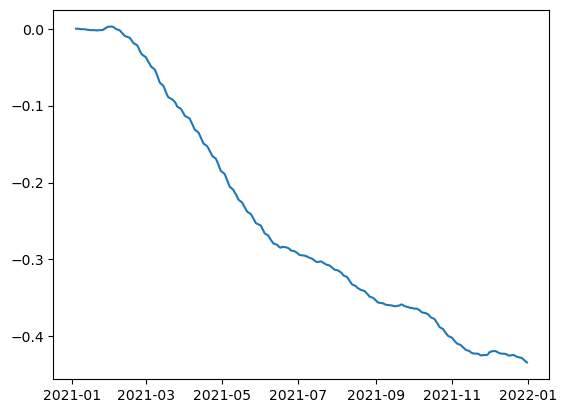

In [335]:
means, covs = kf.filter(trade_raw.iloc[:,1])
plt.plot(trade_raw.index, means[:,0] - means[:,1])

In [15]:
pt = pair_trade(trade_raw)

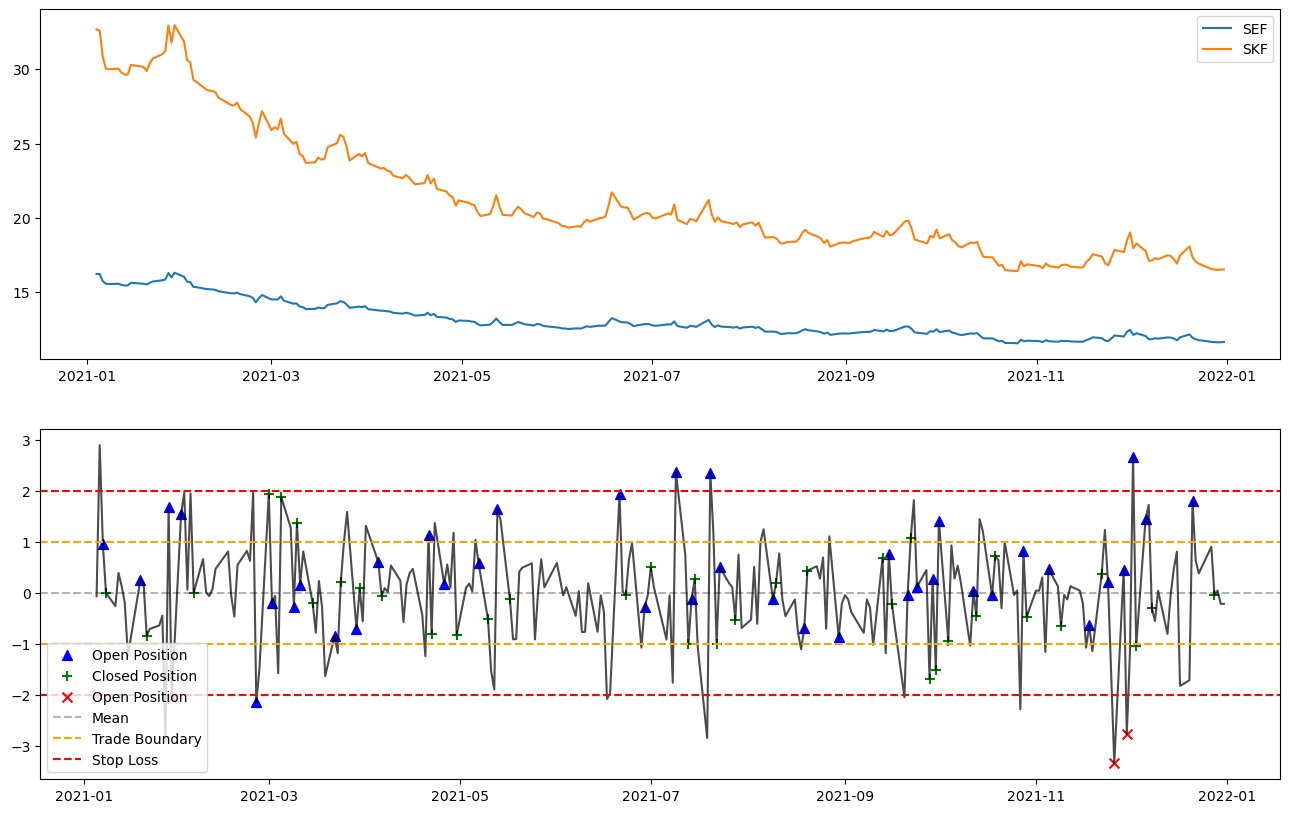

In [16]:
pt.plotting()

In [27]:
np.exp(pt.cum_profits.iloc[-1]) / (np.exp(pt.profit_series) * 100).std()

SEF_SKF    1.578692
dtype: float64

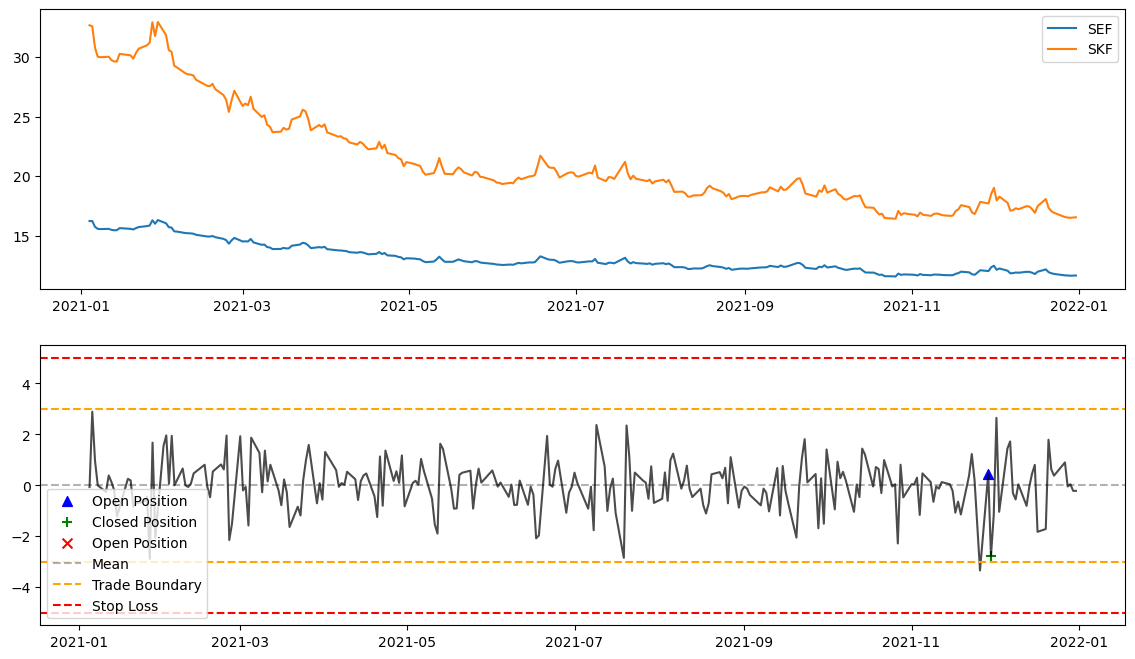

In [273]:
plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(pt.price_df, label=pt.price_df.columns)
plt.legend()

plt.subplot(2,1,2)
plt.scatter( pt.normalized_spread[pt.open_positions].index, pt.normalized_spread[pt.open_positions], marker='^', s=50, c='b', label='Open Position')
plt.scatter( pt.normalized_spread[pt.closed_positions].index, pt.normalized_spread[pt.closed_positions], marker='+', s=50, c='g', label='Closed Position')
plt.scatter( pt.normalized_spread[pt.stop_losses].index, pt.normalized_spread[pt.stop_losses], marker='x', s=50, c='r', label='Open Position')
plt.plot(pt.normalized_spread, c='black', alpha=0.7)
plt.axhline(pt.normalized_spread.mean(), linestyle='--', c='black', alpha=0.3, label='Mean')
plt.axhline(-pt.TRADE_BOUND, linestyle='--', c='orange', label='Trade Boundary')
plt.axhline( pt.TRADE_BOUND, linestyle='--', c='orange')
plt.axhline(-pt.STOP_LOSS,   linestyle='--', c='red', label='Stop Loss')
plt.axhline( pt.STOP_LOSS,   linestyle='--', c='red')
plt.legend()
plt.show()

In [10]:
'''Split Size'''
# size = 0.7 #foundation size
# length = int(len(price_df) * size)
# price_trade = price_df.iloc[length:]

price_found = price_df.loc['2015':'2020']
price_trade = price_df.loc['2021':'2021']
price_found

NameError: name 'price_df' is not defined

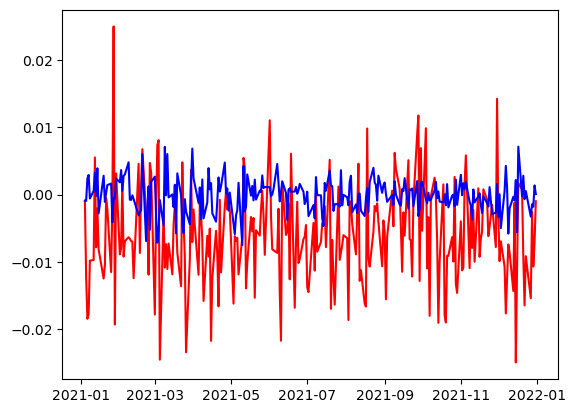

In [135]:
'''빨간색이 맞음'''

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

beta = sm.OLS(price_trade.iloc[:, 1], np.c_[np.ones((len(price_trade))), price_trade.iloc[:, 0]]).fit().params[1]

spread = price_trade.iloc[0, 1] - beta * price_trade.iloc[:, 0]
spread2 = price_trade.iloc[:, 1] - beta * price_trade.iloc[:, 0]
# plt.figure(figsize=(14, 10))
# plt.plot(price_trade.iloc[:, 1] - beta * price_trade.iloc[:, 0], c='b')
# plt.plot(price_trade.iloc[:,0] - price_trade.iloc[:,1], c='g')

#plt.plot((price_trade.iloc[:, 1] - beta * price_trade.iloc[:, 0]) - (price_trade.iloc[:,0] - price_trade.iloc[:,1]), c='r')

#normalized_spread = (spread - spread.mean()) / spread.std()
#plt.plot(normalized_spread)
plt.plot(spread, c='r')
plt.plot(spread2, c='b')

In [9]:
pt = pair_trade(price_trade)
# plt.plot(pt.normalized_spread)
# plt.axhline( 2 * pt.normalized_spread.std(), c='r')
# plt.axhline(-2 * pt.normalized_spread.std(), c='r')
pt.eligible()

NameError: name 'price_trade' is not defined

In [64]:
price_trade

,XLV,VHT
Date,,
2021-01-04,-0.004329,-0.005153
2021-01-05,0.007234,0.006136
2021-01-06,0.013619,0.015727
2021-01-07,0.012922,0.015571
2021-01-08,0.004782,0.004103
...,...,...
2022-10-24,0.019099,0.016048
2022-10-25,0.007569,0.010431
2022-10-26,0.011019,0.011902


In [90]:
cum_ret.iloc[-1].item()

0.8330274444202624

In [23]:
cum_ret = pair_trade(price_trade).cum_profits
pro_ser = pair_trade(price_trade).profit_series

NameError: name 'price_trade' is not defined

In [110]:
cum_ret.iloc[-1].item() / pro_ser.std()

XLV_VHT    111.264532
dtype: float64